## Results
***

0. [Loading data and style setup](#load)
1. [Q1: Performance of XGBoost with respect to classic models](#q1)
1. [Q2: Impact of the features on the models' explainability](#q2)

### 0. Loading data and style setup

In [1]:
%%capture
%run 4_analysis.ipynb

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.boxed {
        background: lightgrey;
        color: black;
        border: 3px solid black;
        margin: 0px auto;
        width: 100%;
        padding: 10px;
        border-radius: 10px;
      }
</style>
""")

### Q1: Performance of XGBoost with respect to classic models<a id='q1'>

In this section, we will understand the meaning of the scores we obtained from the analysis in order to answer the first question exposed in the <a href='0_abstract.ipynb'>abstract</a>:
<ul><li><b>Does our XGBoost outperforms the 7 state-of-the-art ML classifiers for defect prediction?</b></li></ul>

To answer this question, let's explore our scores:

In [3]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if cell else '' for cell in is_max]

In [4]:
models = [
    'Logistic Regression',
    'Naive Bayes Classifier',
    'K-Nearest Neighbor',
    'Neural Network',
    'Support Vector Machine',
    'Decision Tree',
    'Random Forest',
    'XG-Boost'
]

**AUC Scores**

In [5]:
auc = pd.DataFrame(auc_scores)
auc.index = [name.upper() for name in names]
auc.columns = models
auc = auc.transpose()
auc['mean'] = np.mean(auc, axis=1)
auc.style.apply(highlight_max)

,ANT,CAMEL,JEDIT,LOG4J,TOMCAT,VELOCITY,XALAN,XERCES,mean
Logistic Regression,0.690153,0.509164,0.713705,0.684783,0.575381,0.649510,0.563364,0.623377,0.626180
Naive Bayes Classifier,0.728900,0.613578,0.701510,0.766304,0.561829,0.664216,0.650154,0.555195,0.655211
K-Nearest Neighbor,0.656394,0.515875,0.558653,0.684783,0.484472,0.705882,0.587174,0.500000,0.586654
Neural Network,0.613299,0.572664,0.606272,0.619565,0.611519,0.647059,0.567012,0.659091,0.612060
Support Vector Machine,0.679795,0.519231,0.499419,0.641304,0.496894,0.541667,0.523810,0.500000,0.550265
Decision Tree,0.694118,0.615126,0.652729,0.597826,0.583569,0.558824,0.642089,0.626623,0.621363
Random Forest,0.741944,0.605318,0.761905,0.744565,0.578487,0.676471,0.583141,0.636364,0.666024
XG-Boost,0.740281,0.652943,0.797329,0.722826,0.708639,0.730392,0.741359,0.659091,0.719108


**F1 Scores**

In [6]:
f1 = pd.DataFrame(f1_scores)
f1.index = [name.upper() for name in names]
f1.columns = models
f1 = f1.transpose()
f1['mean'] = np.mean(f1, axis=1)
f1.style.apply(highlight_max)

,ANT,CAMEL,JEDIT,LOG4J,TOMCAT,VELOCITY,XALAN,XERCES,mean
Logistic Regression,0.811134,0.786833,0.772099,0.823045,0.910060,0.748841,0.823808,0.836439,0.814032
Naive Bayes Classifier,0.806355,0.819083,0.757664,0.804233,0.848257,0.766908,0.836226,0.780676,0.802425
K-Nearest Neighbor,0.787573,0.793292,0.620296,0.823045,0.890386,0.794506,0.836304,0.775641,0.790130
Neural Network,0.774998,0.814116,0.670144,0.738977,0.906977,0.720934,0.811828,0.852622,0.786325
Support Vector Machine,0.807889,0.796534,0.544032,0.767050,0.902214,0.676347,0.804520,0.775641,0.759278
Decision Tree,0.761134,0.787683,0.701149,0.710444,0.873661,0.609891,0.825830,0.810330,0.760015
Random Forest,0.823612,0.840200,0.822274,0.774790,0.913882,0.757404,0.831271,0.853829,0.827158
XG-Boost,0.833180,0.853280,0.846031,0.744974,0.930233,0.768636,0.864643,0.852622,0.836700


In [7]:
savecsv(auc, fileName = 'Table1_AUC', folder_path = RESULTS_PATH)
savecsv(f1, fileName = 'Table2_F1', folder_path = RESULTS_PATH)

Let's plot our scores to have an overview

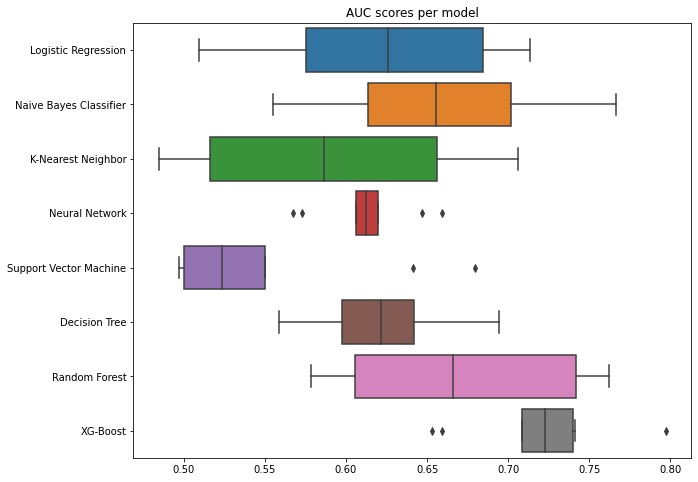

<Figure size 432x288 with 0 Axes>

In [8]:
def boxplot_auc():
    plt.figure(figsize=(10,8))
    sns.boxplot(data=auc.transpose(), orient='h')
    plt.title('AUC scores per model')
    plt.show()
    savefig('Fig1_AUCs', folder_path = RESULTS_PATH)
    
boxplot_auc()

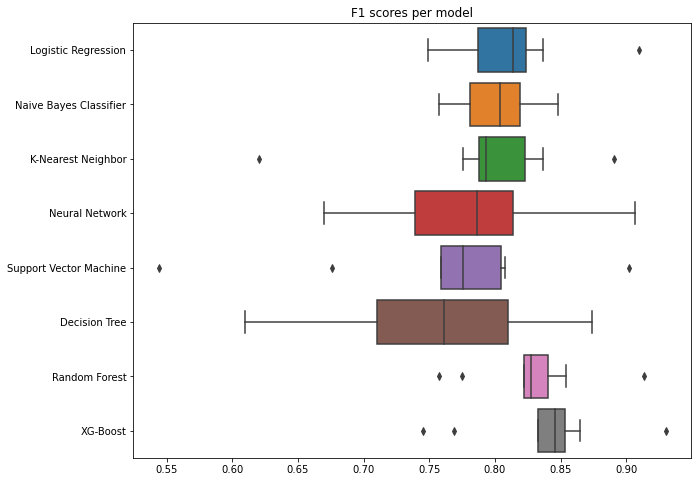

<Figure size 432x288 with 0 Axes>

In [9]:
def boxplot_f1():
    plt.figure(figsize=(10,8))
    sns.boxplot(data=f1.transpose(), orient='h')
    plt.title('F1 scores per model')
    plt.show()
    savefig('Fig2_F1', folder_path = RESULTS_PATH)
    
boxplot_f1()

<div class='boxed'>
    <b>Q1: </b>Literature often considers Random Forest as a relevant model for defect prediction. As we can see from our results, it is indeed a strong model, but not the best one. By studying AUC and F1, our XGBoost outperformed classical models in almost all datasets, and his average is by far the highest one among all the models. We can conclude that, by overall, XGBoost is the best among these to predict software defects.
</div>

### Q2: Impact of the features on the models' explainability<a id='q2'>

Our datasets have 20 features each. Of course, an high number of features increases the prediction's accuracy, but it makes the model *less explainable*. For example, a developer of `ant` could use our model to know if a module of his code will be defective or not, and he would be pretty confident about the result, but he wouldn't know the main reason. He will need a way to find which of that features is most likely the one that leads to the presence of one or more defects.

In order to discover which of the features is more relevant to the models, we will use a measure called **SHAP Value**. 

SHAP Values (acronym for *SHapley Additive exPlanations*) show the impact of each feature on the prediction of the model. Shapley values are a widely used approach from cooperative game theory. The essence of Shapley value is to measure the contributions to the final outcome from each player separately among the coalition, while preserving the sum of contributions being equal to the final outcome. When using SHAP values in model explanation, we can measure the input features’ contribution to individual predictions.

We will implement SHAP Values by **installing and importing *shap* library** (it can be installed in anaconda by running `conda install -c conda-forge shap`)

In [10]:
import shap
shap.initjs()

Let's understand SHAP Values by exploring them on XGBoost applied on `ant`

In [67]:
def compute_shap_values(dataset):
    XGB = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', **best_params[dataset])
    model = XGB.fit(X_train[dataset], y_train[dataset])
    X = pd.concat([X_train[dataset], X_test[dataset]], axis=0)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)
    return shap_values, X

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


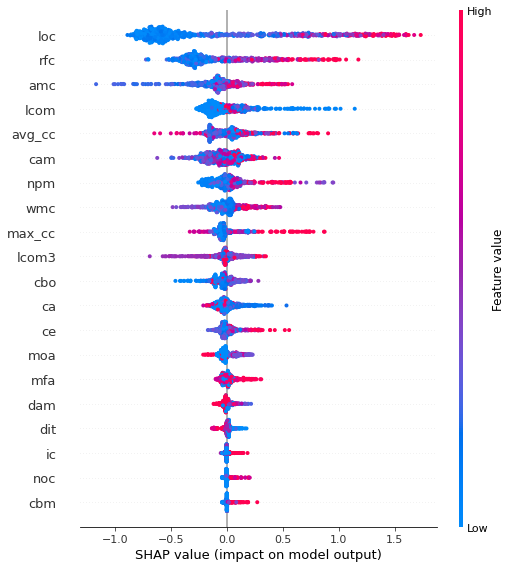

In [68]:
shap_values, X = compute_shap_values('ant')
shap.summary_plot(shap_values)

**How to read SHAP values?** Let's have a look to the plot above:

First of all, every point represent an observation of a feature. The color of the point stands for the feature value, as explained by the legend on the right. Light blue points are observations of a feature with a low value, while red ones are high values. 

We can see how these points are distributed along a line, that represents, indeed, the SHAP Value of that observation. The SHAP value explains the impact that a feature observation has on the output. SHAPs on the left of the vertical line (negative SHAPs) leads to the prediction of a 0, and vice-versa. The more a SHAP value is high, the more it leads to the presence of a defect in the class.

In this sense, a feature is relevant when there is a sort of correlation (even positive or negative) between the value of an observation and his SHAP value.

In the plot, features are already sorted by importance. In fact, if we compute the main of each SHAP value grouped by feature, we can extract the most relevant features:

In [69]:
def get_values_dict(shap_values, X):
    values_dict = dict()
    for i in range(len(X.columns)):
        values_dict[X.columns[i]] = np.abs(shap_values.values).mean(0)[i]
    values_dict_sorted = {k: v for k, v in sorted(values_dict.items(), key=lambda item: item[1], reverse=True)}
    return values_dict_sorted

In [70]:
shaps = dict()
shaps['ant'] = get_values_dict(shap_values, X)

In [71]:
shaps['ant']

{'loc': 0.6407821,
 'rfc': 0.29117027,
 'amc': 0.15477319,
 'lcom': 0.14949627,
 'avg_cc': 0.13080421,
 'cam': 0.115132295,
 'npm': 0.11320557,
 'wmc': 0.09769897,
 'max_cc': 0.09116721,
 'lcom3': 0.07898944,
 'cbo': 0.068246886,
 'ca': 0.06644558,
 'ce': 0.052117996,
 'moa': 0.051839113,
 'mfa': 0.04135763,
 'dam': 0.026629709,
 'dit': 0.019612096,
 'ic': 0.014243698,
 'noc': 0.0138257835,
 'cbm': 0.0138221355}

How can we understand these informations? We can see how, apart from `loc`, every feature has a very low SHAP value, meaning that, even if they can improve model's accuracy, they have the opposite effect on the model's explainability. The most understandable model, in the case of `ant`, would be in fact a model that takes into consideration just `loc` to predict `defects`

We can obtain the list of features sorted by importance

In [26]:
features = X.columns[np.argsort(-np.abs(shap_values.values).mean(0))]

In [27]:
print(list(features))

['loc', 'rfc', 'amc', 'lcom', 'avg_cc', 'cam', 'npm', 'wmc', 'max_cc', 'lcom3', 'cbo', 'ca', 'ce', 'moa', 'mfa', 'dam', 'dit', 'ic', 'noc', 'cbm']


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


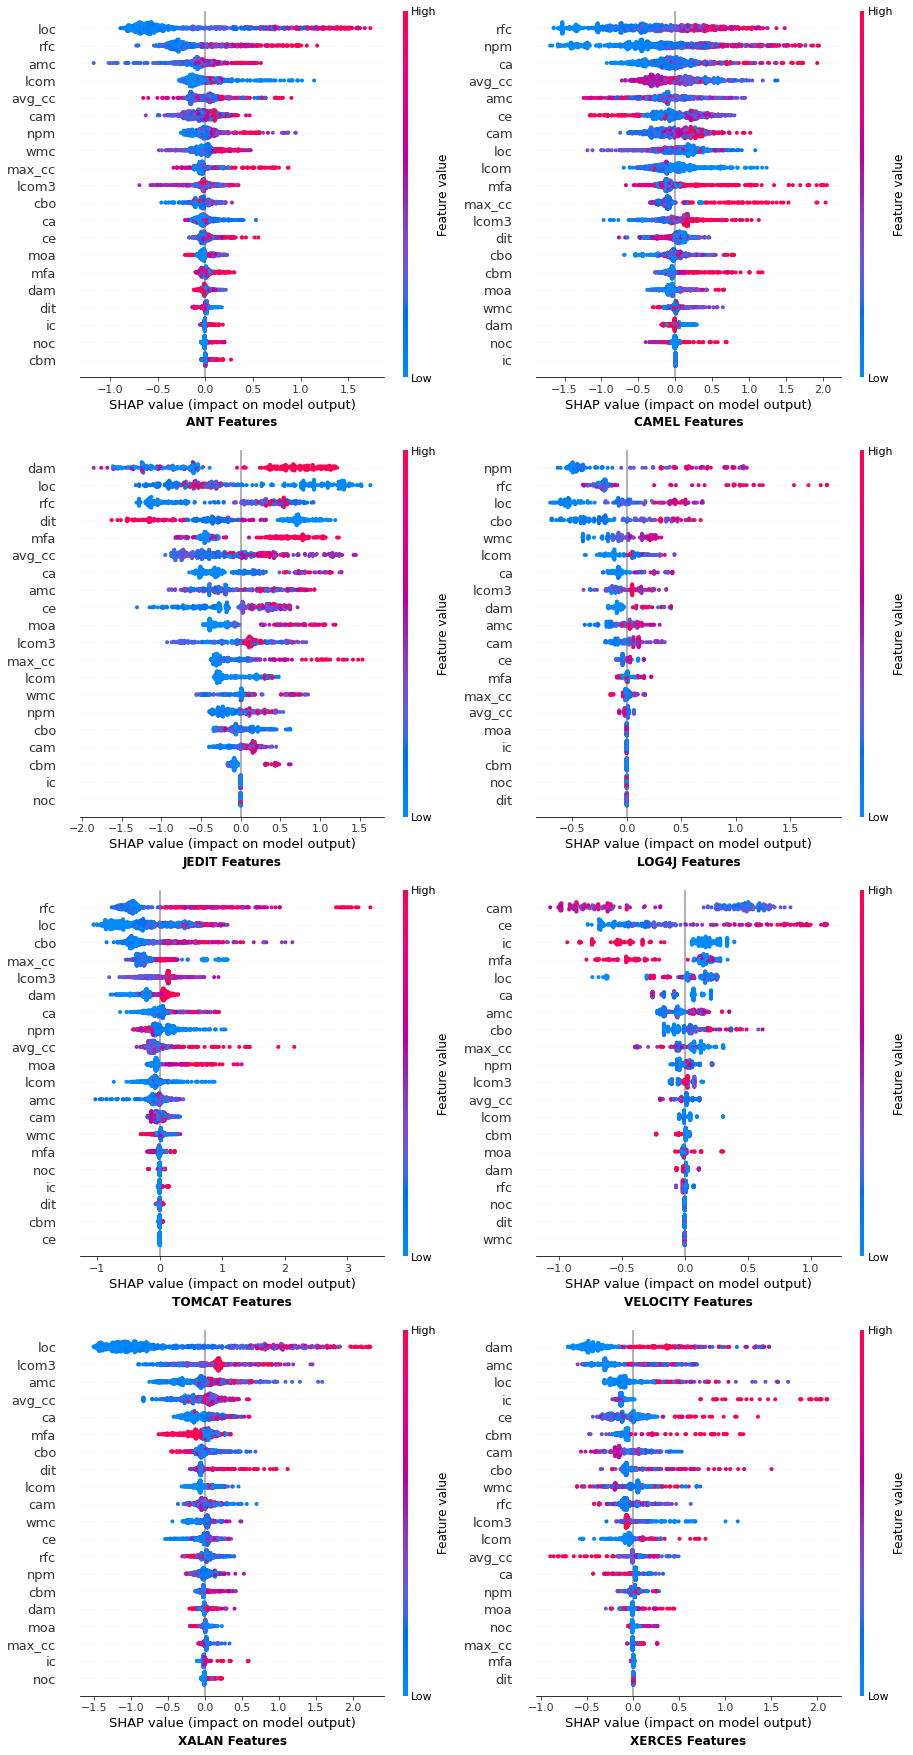

In [72]:
plt.figure(figsize=(15,31))
titles = [name.upper() + ' Features' for name in names]
iter = 0
for i in range(4):
    for j in range(2):
        shap_values, X = compute_shap_values(names[iter])
        shaps[names[iter]] = get_values_dict(shap_values, X)
        plt.subplot(4,2,iter+1)
        plt.title(titles[iter], fontweight = "bold", y=-0.15)
        shap.summary_plot(shap_values, plot_size = None, show = False)
        iter += 1
plt.show()

Let's explore all SHAP values of the models

In [73]:
pd.DataFrame(shaps)

,ant,camel,jedit,log4j,tomcat,velocity,xalan,xerces
loc,0.640782,0.223071,0.782629,0.352869,0.465559,0.191563,0.943503,0.227275
rfc,0.291170,0.594052,0.652372,0.398510,0.569393,0.017325,0.072015,0.109479
amc,0.154773,0.268123,0.392372,0.108001,0.104148,0.112681,0.257325,0.298070
lcom,0.149496,0.212135,0.232727,0.136947,0.121350,0.027652,0.092701,0.097809
avg_cc,0.130804,0.286955,0.481934,0.023927,0.137773,0.043671,0.185505,0.079825
cam,0.115132,0.230839,0.142115,0.096277,0.072899,0.595785,0.088154,0.141725
npm,0.113206,0.593277,0.200844,0.523809,0.150399,0.049787,0.071151,0.041530
wmc,0.097699,0.055358,0.206803,0.158825,0.049301,0.000000,0.079180,0.131123
max_cc,0.091167,0.188813,0.293902,0.035389,0.290805,0.108861,0.025871,0.016613
lcom3,0.078989,0.179926,0.297196,0.119545,0.194353,0.047396,0.277457,0.102213


In [88]:
def highlight_relevant_shaps(shap_df):
    is_relevant = (shap_df >= 0.45)
    return ['font-weight: bold' if cell else '' for cell in is_relevant]

shaps_df = pd.DataFrame(shaps)
shaps_df.style.apply(highlight_relevant_shaps)

,ant,camel,jedit,log4j,tomcat,velocity,xalan,xerces
loc,0.640782,0.223071,0.782629,0.352869,0.465559,0.191563,0.943503,0.227275
rfc,0.291170,0.594052,0.652372,0.398510,0.569393,0.017325,0.072015,0.109479
amc,0.154773,0.268123,0.392372,0.108001,0.104148,0.112681,0.257325,0.298070
lcom,0.149496,0.212135,0.232727,0.136947,0.121350,0.027652,0.092701,0.097809
avg_cc,0.130804,0.286955,0.481934,0.023927,0.137773,0.043671,0.185505,0.079825
cam,0.115132,0.230839,0.142115,0.096277,0.072899,0.595785,0.088154,0.141725
npm,0.113206,0.593277,0.200844,0.523809,0.150399,0.049787,0.071151,0.041530
wmc,0.097699,0.055358,0.206803,0.158825,0.049301,0.000000,0.079180,0.131123
max_cc,0.091167,0.188813,0.293902,0.035389,0.290805,0.108861,0.025871,0.016613
lcom3,0.078989,0.179926,0.297196,0.119545,0.194353,0.047396,0.277457,0.102213


In order to extract the most relevant features, we can define a threshold value. Observing the data and the SHAPs, we define to set it at 0.45 as every feature with a SHAP greater or equal to 0.45 is interpreted as a relevant feature.

In [108]:
def get_relevant_features(shap_dict):
    return list({k: v for (k, v) in shap_dict.items() if v >= 0.45}.keys())

In [109]:
features = dict()
for key in names:
    features[key] = get_relevant_features(shaps[key])

In [110]:
features

{'ant': ['loc'],
 'camel': ['rfc', 'npm'],
 'jedit': ['dam', 'loc', 'rfc', 'dit', 'mfa', 'avg_cc'],
 'log4j': ['npm'],
 'tomcat': ['rfc', 'loc'],
 'velocity': ['cam', 'ce'],
 'xalan': ['loc'],
 'xerces': ['dam']}

Now we'll plot SHAP values of relevant features for each dataset

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


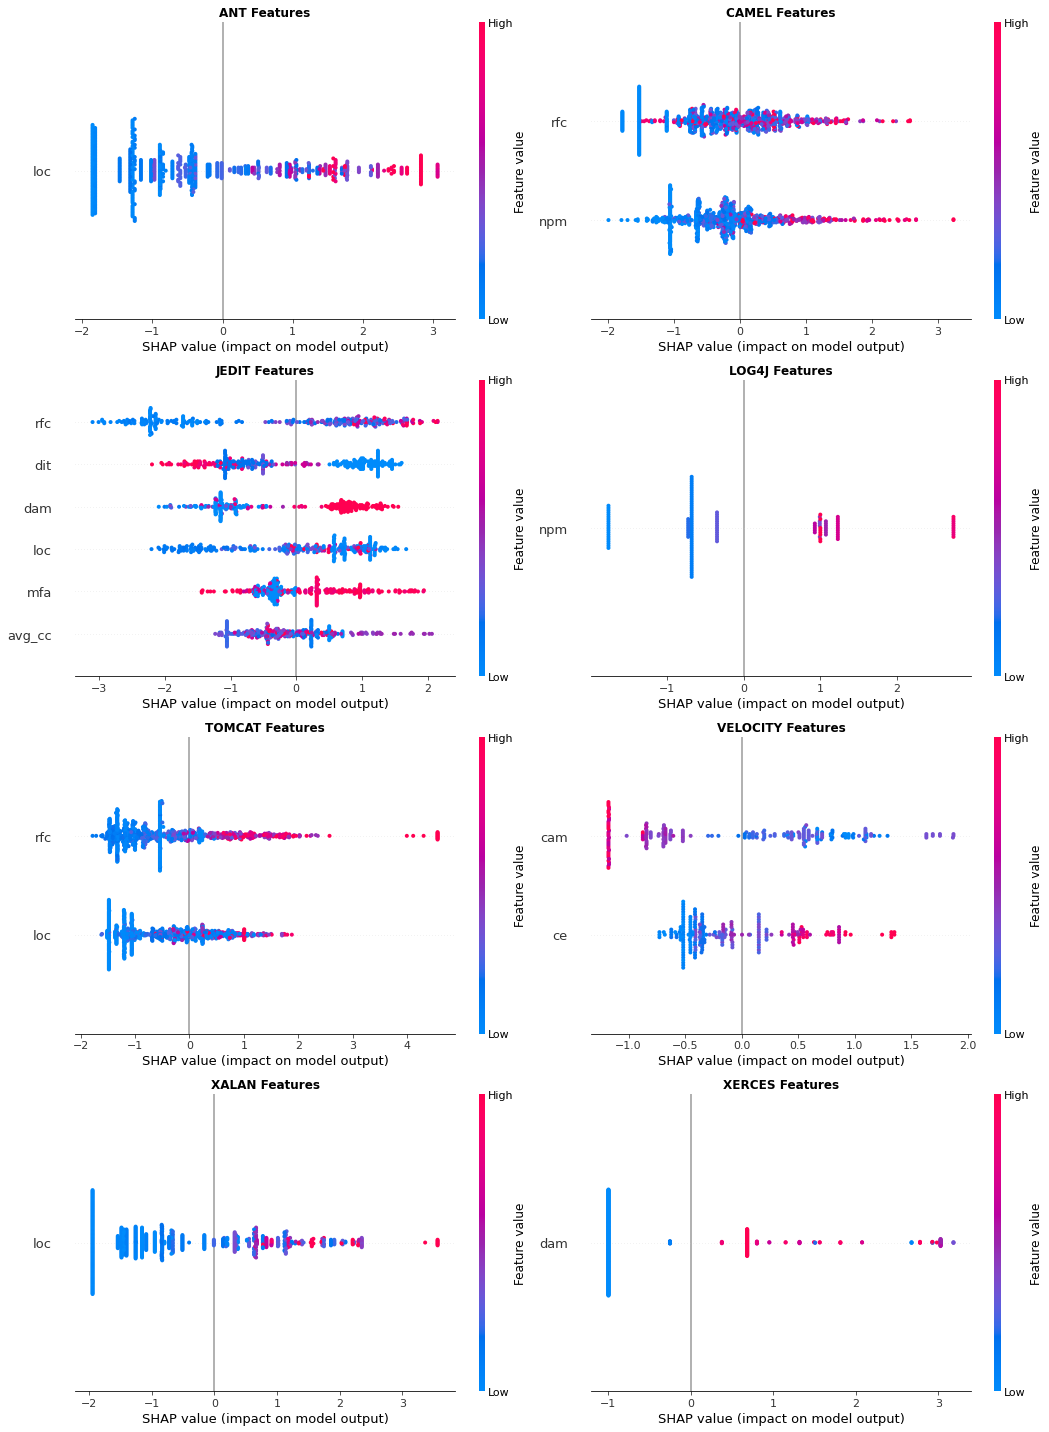

In [123]:
plt.figure(figsize=(15,20))
titles = [name.upper() + ' Features' for name in names]
iter = 0
for i in range(4):
    for j in range(2):
        XGB = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', **best_params[names[iter]])
        XGB_X_train = pd.DataFrame(X_train[names[iter]][features[names[iter]]])
        XGB_y_train = y_train[names[iter]]
        XGB_X_test = pd.DataFrame(X_test[names[iter]][features[names[iter]]])
        model = XGB.fit(XGB_X_train, XGB_y_train)
        X = pd.concat([XGB_X_train, XGB_X_test], axis=0)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X)
        shaps[names[iter]] = get_values_dict(shap_values, X)
        plt.subplot(4,2,iter+1)
        plt.title(titles[iter], fontweight = "bold")
        shap.summary_plot(shap_values, plot_size = None, show = False)
        iter += 1
plt.tight_layout()
savefig('Fig3_SHAP_values', folder_path = RESULTS_PATH)
plt.show()

<div class='boxed'>
    <b>Q2: </b>In the analysis, we predicted the presence of defects by using the full feature space. However, we noticed that the biggest part of those features are not relevant in the process of prediction. In fact, the only effect they had was to reduce the explainability of the model. We conclude that is better to build models that only have few features (even just one or two, as we can see from the plot above), as, this way, a developer of the related project can immediatly focus on the features that are most likely the cause of the defect, instead of analyzing the hole feature space.
</div>